# anthracene

Look at serial code profiled timings
Compare this to parallel code profiled timings



In [2]:
%load_ext autoreload
%autoreload 2

import json
import textwrap

from isdfbenchmarks.submission import remote


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Remote instance
mpsd_remote = remote.Remote("bucchera", "mpsd-hpc-login1.desy.de", venv="/home/bucchera/programs/isdfBenchmarks/.venv")

In [7]:
# Execute parser on remote, and stream data back

code = textwrap.dedent(r"""
import json

from isdfbenchmarks.parser.profiling import parse_time
from isdfbenchmarks.parser.parse_dir import parse_file_instances


cumulative, self = parse_time("/home/bucchera/exchange_calcs/isdf/24_anthracene/profiling/time.000000")
results = {'cumulative': cumulative, 'self':self}
print(json.dumps(results))
""")

stdout = mpsd_remote.execute_script(code)
isdf_results = json.loads(stdout)

In [8]:
# Reference ACE profiling

code = textwrap.dedent(r"""
import json

from isdfbenchmarks.parser.profiling import parse_time
from isdfbenchmarks.parser.parse_dir import parse_file_instances


cumulative, self = parse_time("/home/bucchera/exchange_calcs/repeat_reference_ace/24_anthracene/profiling/time.000000")
results = {'cumulative': cumulative, 'self':self}
print(json.dumps(results))
""")

stdout = mpsd_remote.execute_script(code)
ref_results = json.loads(stdout)


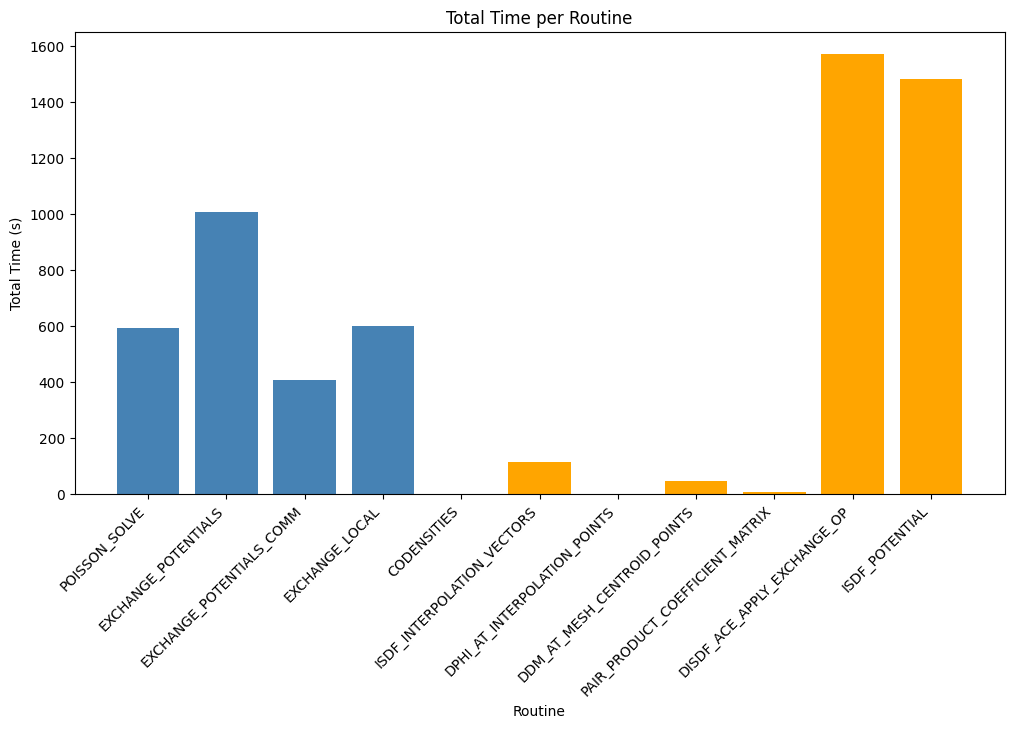

In [14]:
""" Call hierarchy
isdf_interpolation_vectors             -> isdf_interpolation_vectors
	dphi_at_interpolation_points       -> dphi_at_interpolation_points
	dquasi_density_matrix_at_mesh_centroid_points   -> ddm_at_mesh_centroid_points
	pair_product_coefficient_matrix    -> pair_product_coefficient_matrix
disdf_ace_apply_exchange_op            -> disdf_ace_apply_exchange_op  
	isdf_potential                     -> isdf_potential 
	Rest of it   
	
Operations not wrapped for timing:
    P_mu_nu = [psi_ist_mu]^T @ psi_ist_nu
    lalg_svd_inverse
    call symmetrize_matrix(n_int_g, cct)
    ! zeta = [ZC^T][CC^T]^-1
    Kmeans
"""
import matplotlib.pyplot as plt
import numpy as np

# EXCHANGE_POTENTIALS should be equivalent to ISDF_INTERPOLATION_VECTORS + DISDF_ACE_APPLY_EXCHANGE_OP

# Reference routines
ref_routines = ['POISSON_SOLVE', 
                'EXCHANGE_POTENTIALS', 
                'EXCHANGE_POTENTIALS_COMM', 
                'EXCHANGE_LOCAL', 
                'CODENSITIES']

ref_time_per_call = [ref_results['cumulative'][name]['TIME_PER_CALL'] for name in ref_routines]
ref_total_time = [ref_results['cumulative'][name]['TOTAL_TIME'] for name in ref_routines]

# Extract times of relevant routines
isdf_routines = ['ISDF_INTERPOLATION_VECTORS',
            'DPHI_AT_INTERPOLATION_POINTS',
            'DDM_AT_MESH_CENTROID_POINTS',
            'PAIR_PRODUCT_COEFFICIENT_MATRIX',
            'DISDF_ACE_APPLY_EXCHANGE_OP',
            'ISDF_POTENTIAL']


cumulative_times = isdf_results['cumulative']
self_times = isdf_results['self']
isdf_time_per_call = [cumulative_times[name]['TIME_PER_CALL'] for name in isdf_routines]
isdf_total_time = [cumulative_times[name]['TOTAL_TIME'] for name in isdf_routines]

# Plot
x_ref = np.arange(len(ref_routines))
x_isdf = np.arange(len(isdf_routines)) + len(ref_routines)

# Combined ticks/labels
x_all = np.concatenate([x_ref, x_isdf])
labels = ref_routines + isdf_routines

plt.figure(figsize=(12, 6))
plt.bar(x_ref, ref_total_time, label='Reference', color='steelblue')
plt.bar(x_isdf, isdf_total_time, label='ISDF', color='orange')

plt.xlabel('Routine')
plt.ylabel('Total Time (s)')
plt.title('Total Time per Routine')
plt.xticks(x_all, labels, rotation=45, ha='right')
plt.show()


In [25]:
def parse_and_plot_bars(ref_dir: str, isdf_dir: str):
    
    code = textwrap.dedent(rf"""
import json

from isdfbenchmarks.parser.profiling import parse_time
from isdfbenchmarks.parser.parse_dir import parse_file_instances


cumulative, self = parse_time("{isdf_dir}/profiling/time.000000")
results = {{'cumulative': cumulative, 'self':self}}
print(json.dumps(results))
""")

    stdout = mpsd_remote.execute_script(code)
    isdf_results = json.loads(stdout)
    
    code = textwrap.dedent(rf"""
import json

from isdfbenchmarks.parser.profiling import parse_time
from isdfbenchmarks.parser.parse_dir import parse_file_instances


cumulative, self = parse_time("{ref_dir}/profiling/time.000000")
results = {{'cumulative': cumulative, 'self':self}}
print(json.dumps(results))
""")

    stdout = mpsd_remote.execute_script(code)
    ref_results = json.loads(stdout)
    
    # EXCHANGE_POTENTIALS should be equivalent to ISDF_INTERPOLATION_VECTORS + DISDF_ACE_APPLY_EXCHANGE_OP

    # Reference routines
    ref_routines = ['POISSON_SOLVE', 
                    'EXCHANGE_POTENTIALS', 
                    'EXCHANGE_POTENTIALS_COMM', 
                    'EXCHANGE_LOCAL', 
                    'CODENSITIES']
    
    ref_time_per_call = [ref_results['cumulative'][name]['TIME_PER_CALL'] for name in ref_routines]
    ref_total_time = [ref_results['cumulative'][name]['TOTAL_TIME'] for name in ref_routines]
    
    # Extract times of relevant routines
    isdf_routines = ['ISDF_INTERPOLATION_VECTORS',
                'DPHI_AT_INTERPOLATION_POINTS',
                'DDM_AT_MESH_CENTROID_POINTS',
                'PAIR_PRODUCT_COEFFICIENT_MATRIX',
                'DISDF_ACE_APPLY_EXCHANGE_OP',
                'ISDF_POTENTIAL']
    
    
    cumulative_times = isdf_results['cumulative']
    self_times = isdf_results['self']
    isdf_time_per_call = [cumulative_times[name]['TIME_PER_CALL'] for name in isdf_routines]
    isdf_total_time = [cumulative_times[name]['TOTAL_TIME'] for name in isdf_routines]
    
    # Plot
    x_ref = np.arange(len(ref_routines))
    x_isdf = np.arange(len(isdf_routines)) + len(ref_routines)
    
    # Combined ticks/labels
    x_all = np.concatenate([x_ref, x_isdf])
    labels = ref_routines + isdf_routines
    
    plt.figure(figsize=(12, 6))
    plt.bar(x_ref, ref_total_time, label='Reference', color='steelblue')
    plt.bar(x_isdf, isdf_total_time, label='ISDF', color='orange')
    
    plt.xlabel('Routine')
    plt.ylabel('Total Time (s)')
    plt.title('Total Time per Routine')
    plt.xticks(x_all, labels, rotation=45, ha='right')


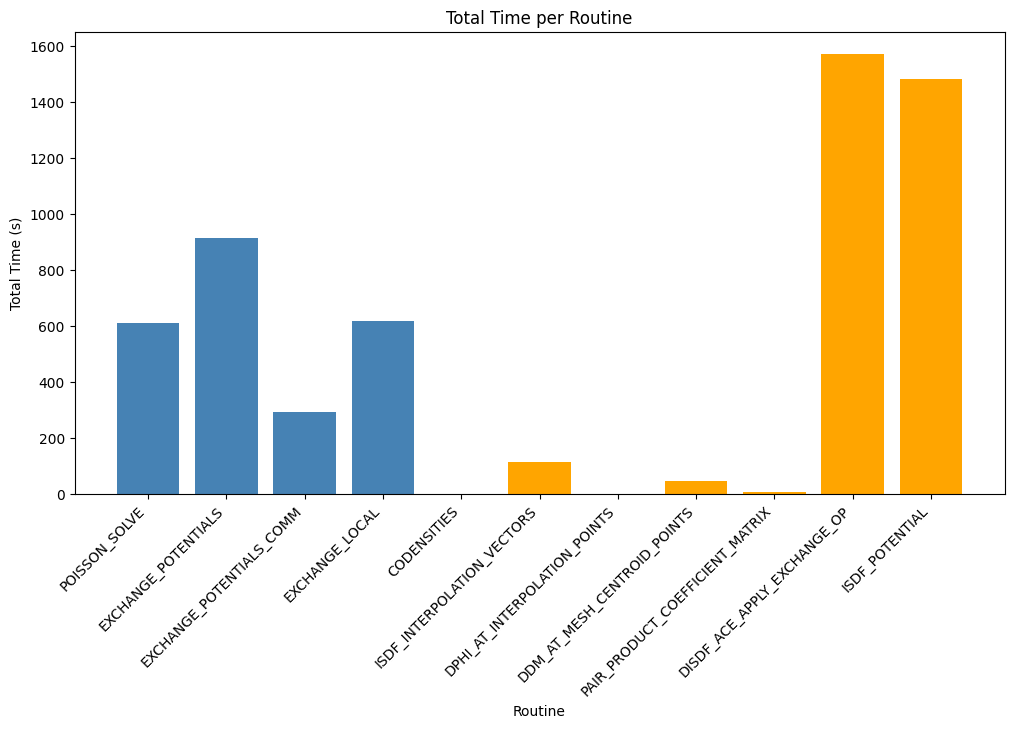

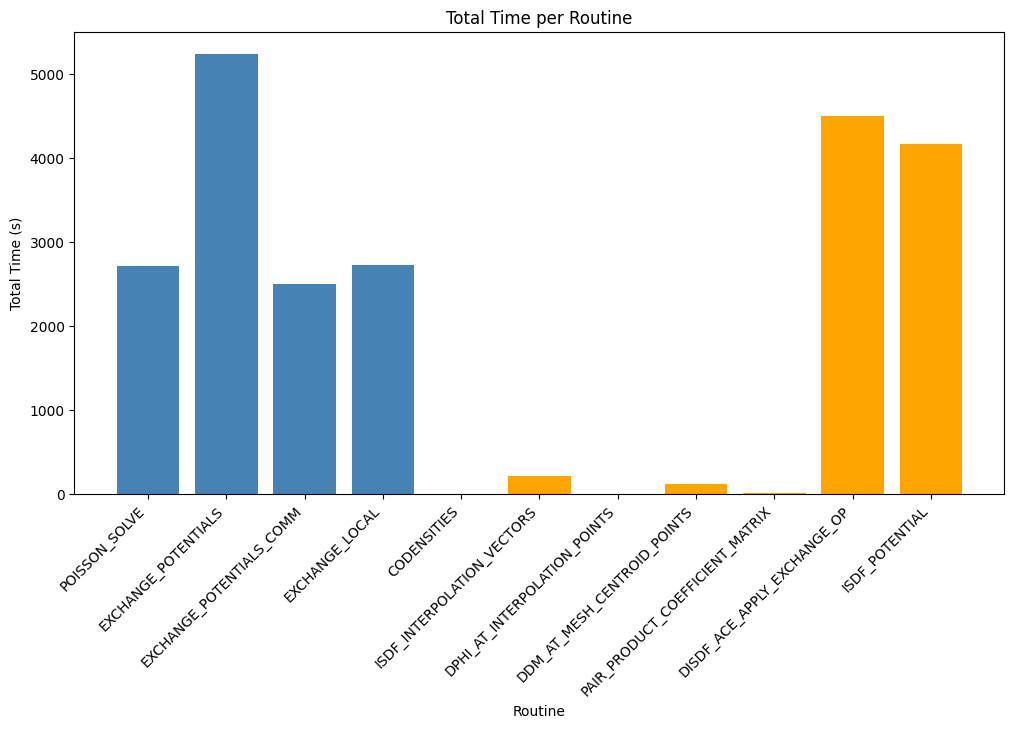

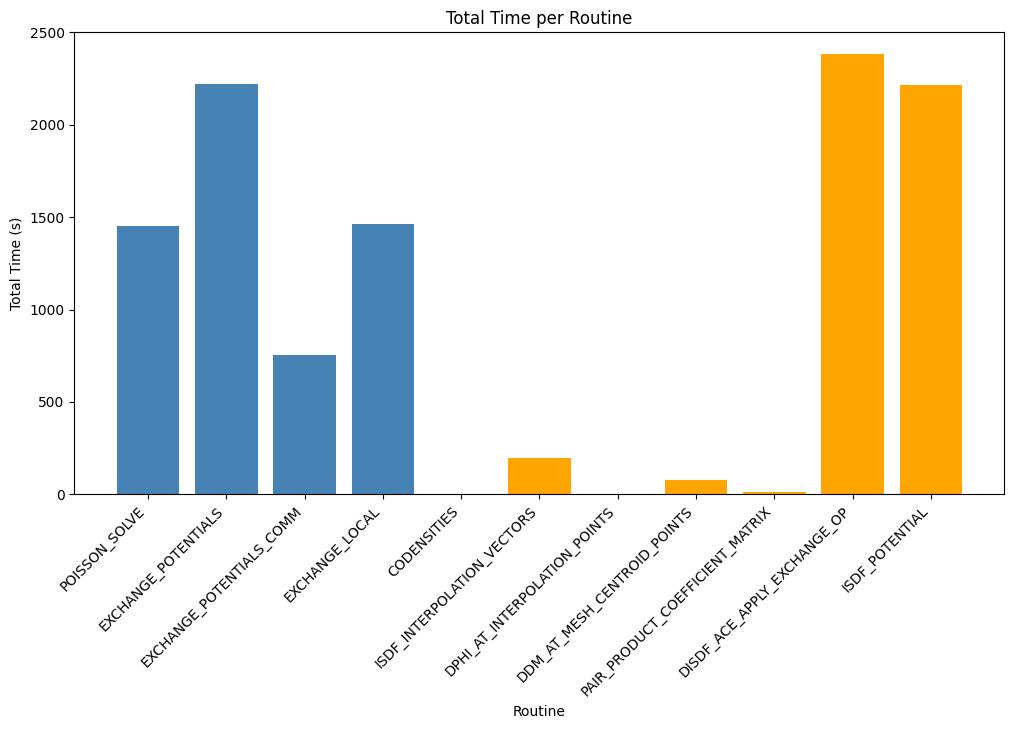

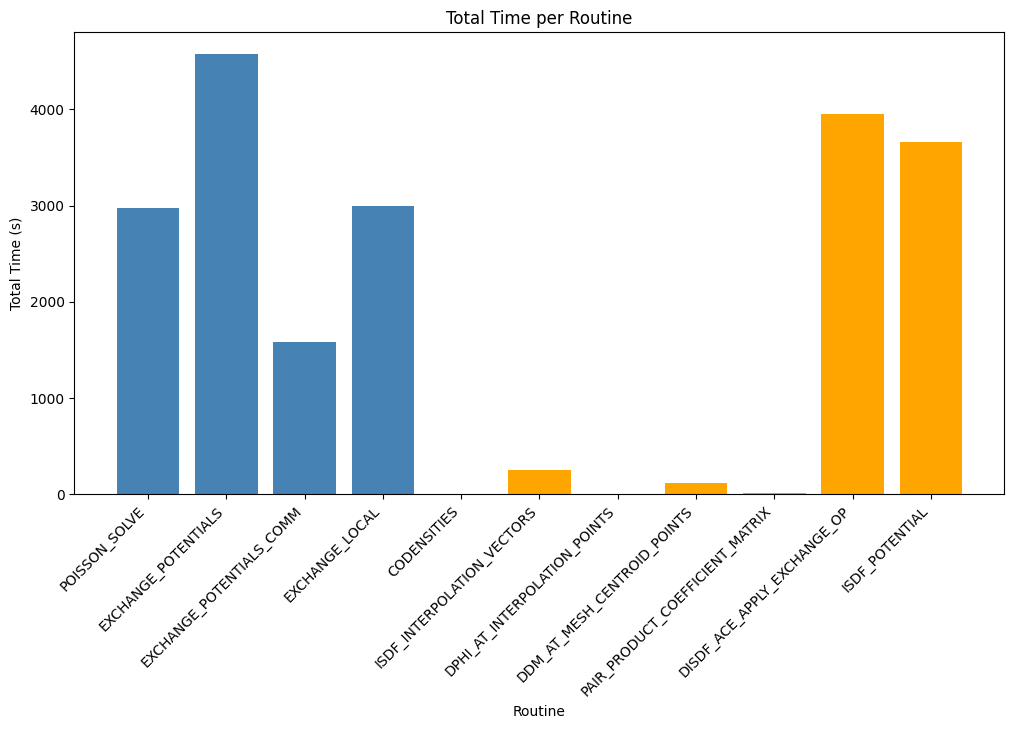

In [28]:
parse_and_plot_bars("/home/bucchera/exchange_calcs/reference_ace/24_anthracene", 
                    "/home/bucchera/exchange_calcs/isdf/24_anthracene")
parse_and_plot_bars("/home/bucchera/exchange_calcs/reference_ace/30_tetracene", 
                    "/home/bucchera/exchange_calcs/isdf/30_tetracene")
parse_and_plot_bars("/home/bucchera/exchange_calcs/reference_ace/36_pentacene", 
                    "/home/bucchera/exchange_calcs/isdf/36_pentacene")
parse_and_plot_bars("/home/bucchera/exchange_calcs/reference_ace/42_ether_crown", 
                    "/home/bucchera/exchange_calcs/isdf/42_ether_crown")

In [18]:
"""
Looks like the Poisson solution is just taking way more time in the ISDF code. Check:
* Octopus builds are consistent + no use of restart data
* Release as well as scalapack use + of setting resources
* Poisson call count in both runs
"""

# Seems to suggest that ISDF is simply calling poisson solver 2.5x more than the reference code. 
print(isdf_results['cumulative']['POISSON_SOLVE']['NUM_CALLS'])
print(ref_results['cumulative']['POISSON_SOLVE']['NUM_CALLS'])


12453
5061


## Initial Data Analysis for Anthracene

Ref:
```
EXCHANGE_POTENTIALS_COMM                           480      408.259299        0.850540        0.000003       0.0       0.0    36.0 |       408.259299        0.850540       0.0       0.0    36.0
POISSON_SOLVE                                     5061      595.460209        0.117657        0.042427       0.0      61.6    52.6 |       329.263829        0.065059       0.0       0.0    29.1
SGFFT                                            10082      259.366159        0.025726        0.022204       0.0       0.0    22.9 |       259.366159        0.025726       0.0       0.0    22.9
```

ISDF:
```
POISSON_SOLVE                                    12453     1486.043079        0.119332        0.043490       0.0      60.7    74.3 |       821.395527        0.065960       0.0       0.0    41.1
SGFFT                                            24862      642.859033        0.025857        0.022608       0.0       0.0    32.2 |       642.859033        0.025857       0.0       0.0    32.2
ISDF_GET_INTERPOLATION_POINTS                       22      190.160663        8.643666        6.451695       0.0       0.0     9.5 |       190.160663        8.643666       0.0       0.0     9.5
```

Running single MPI-process jobs in:

```
/home/bucchera/exchange_calcs/compare_anthracene/ref_np1
/home/bucchera/exchange_calcs/compare_anthracene/isdf_np1_250points
```

Submit the rest and confirm at what number of interpolation points does ISDF converge?
* isdf_np1_350points
* isdf_np1_450points
* isdf_np1_565points

I assume that the Poisson calls are distributed and this roughly scales with the state distribution



In [6]:
""" Average SCF time as a function of Number of occupied states
"""
code = textwrap.dedent(r"""
import json
from pathlib import Path

from isdfbenchmarks.parser import stdout

# All single node jobs. 4 MPI, 8 OMP per process
molecules = ['24_anthracene', '30_tetracene', '36_pentacene', '42_ether_crown']
to_run = ['60_buckminster', '73_chlorophyll', '84_c84']

# Parse SCF per time step
root = Path("/home/bucchera/exchange_calcs/isdf")

isdf_times = {}
for molecule in molecules:
    file = root / molecule / 'terminal.out'
    with open(file, mode='r') as fid:
        lines = fid.read()
    isdf_times[molecule] = stdout.parse_scf_time(lines)

print(json.dumps(isdf_times))
""")
stdout = mpsd_remote.execute_script(code)
isdf_scf = json.loads(stdout)


In [8]:
code = textwrap.dedent(r"""
import json
from pathlib import Path

from isdfbenchmarks.parser import stdout

# All single node jobs. 4 MPI, 8 OMP per process
molecules = ['24_anthracene', '30_tetracene', '36_pentacene', '42_ether_crown']

# Note, these will use more than one node. Either need to normalise OR run the above with more nodes
# For the sake of comparison to reference implementation, it's reasonable to normalise
to_compare = ['60_buckminster', '73_chlorophyll', '84_c84']

# Note, I need to change this to my repeat set of references, to CONFIRM that I have
# used consistent builds for reference and ISDF
root = Path("/home/bucchera/exchange_calcs/reference_ace")
ref_times = {}
for molecule in molecules:
    file = root / molecule / 'terminal.out'
    with open(file, mode='r') as fid:
        lines = fid.read()
    ref_times[molecule] = stdout.parse_scf_time(lines)

print(json.dumps(ref_times))
""")
stdout = mpsd_remote.execute_script(code)
ref_scf = json.loads(stdout)


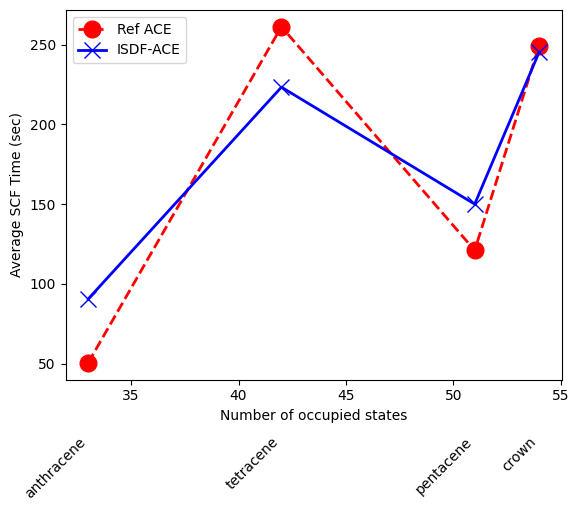

In [21]:
import numpy as np
import matplotlib.pyplot as plt

nocc = {'24_anthracene': 33, '30_tetracene': 42, '36_pentacene': 51, '42_ether_crown': 54}

# Average SCF time vs 
n_molecules = 4
avg_scf = np.empty(shape=(2, n_molecules))

assert list(ref_scf) == list(isdf_scf), "SCF times must be for a consistent set of molecules"

# Occupied states
occupied = [iocc for iocc in nocc.values()]

# Times
i = 0
for key, times in ref_scf.items():
    avg_scf[0, i] = np.mean([time for time in times.values()])
    avg_scf[1, i] = np.mean([time for time in isdf_scf[key].values()])
    i += 1
    

plt.plot(occupied, avg_scf[0, :], 'ro--', linewidth=2, markersize=12, label="Ref ACE")
plt.plot(occupied, avg_scf[1, :], 'bx-', linewidth=2, markersize=12, label="ISDF-ACE")
plt.xlabel("Number of occupied states")
plt.ylabel("Average SCF Time (sec)")

for key, xpos in nocc.items():
    label = key.split('_')[-1]
    plt.text(xpos, plt.ylim()[0] - 0.15*(plt.ylim()[1]-plt.ylim()[0]),
             label, ha='right', va='top', rotation=45)

plt.legend()


In [ ]:
# Plots to make
# * Timing as a function of MPI processes for anthracene






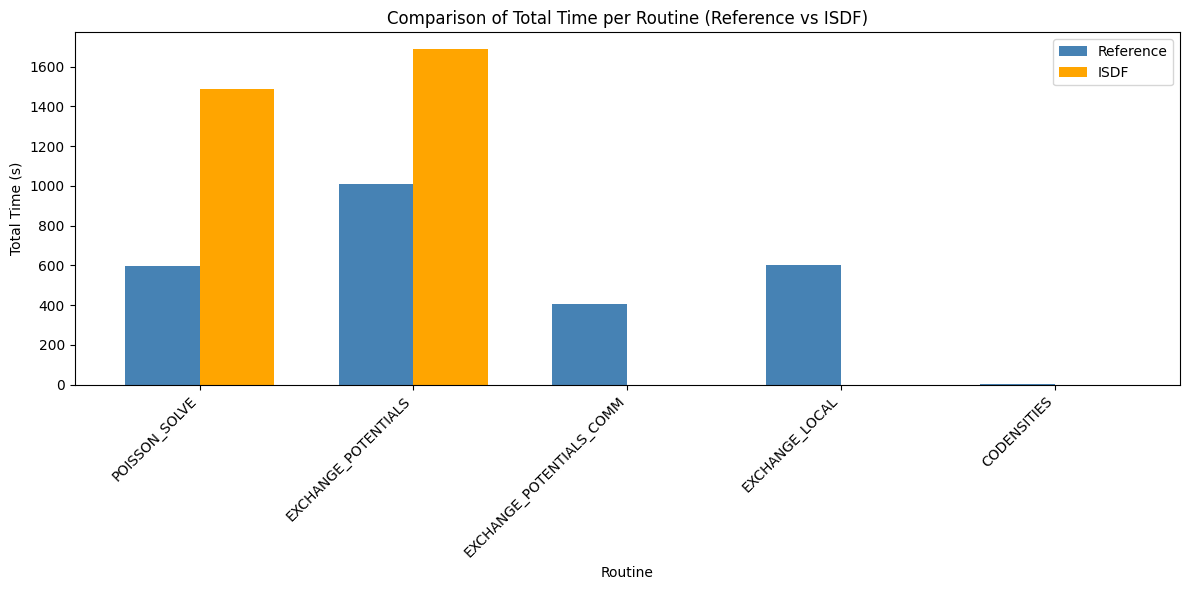

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Combine EXCHANGE_POTENTIALS equivalent for ISDF
isdf_combined_total_time = []
for r in ref_routines:
    if r == "EXCHANGE_POTENTIALS":
        combined_time = (
            cumulative_times['ISDF_INTERPOLATION_VECTORS']['TOTAL_TIME']
            + cumulative_times['DISDF_ACE_APPLY_EXCHANGE_OP']['TOTAL_TIME']
        )
        isdf_combined_total_time.append(combined_time)
    else:
        # Use the same routine name if it exists in isdf_results, else set to 0
        isdf_combined_total_time.append(cumulative_times.get(r, {}).get('TOTAL_TIME', 0))

# Create x-axis positions
x = np.arange(len(ref_routines))
width = 0.35

# Plot
plt.figure(figsize=(12, 6))
plt.bar(x - width/2, ref_total_time, width, label="Reference", color="steelblue")
plt.bar(x + width/2, isdf_combined_total_time, width, label="ISDF", color="orange")

plt.xlabel("Routine")
plt.ylabel("Total Time (s)")
plt.title("Comparison of Total Time per Routine (Reference vs ISDF)")
plt.xticks(x, ref_routines, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()
